### Decoding: Classifying Patterns as 'win' or 'loss'

#### Import Packages 

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import os

import nilearn
from nilearn import decoding, image, plotting

from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_img, show, plot_glass_brain
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from nilearn.decoding import Decoder

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
from nilearn.input_data import NiftiMasker

from statistics import mean

#### Import Models 

Importing the models, images, events and confounds as used in the univariate analysis. 

Further; import the models fitted to the lsa_dm design matrices (where each trial is in its own column), the lsa_dm design matrices, beta maps and condition labels calculated in the 'flm_all_trials.py' script. 

In [2]:
## Load models 
f = open("../out/all_flm_IGT.pkl", 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()
## load beta maps etc
f = open("../out/tbt_all_flm_IGT.pkl", 'rb')
models_t, lsa_dm, b_maps, conditions_labels = pickle.load(f)
f.close()

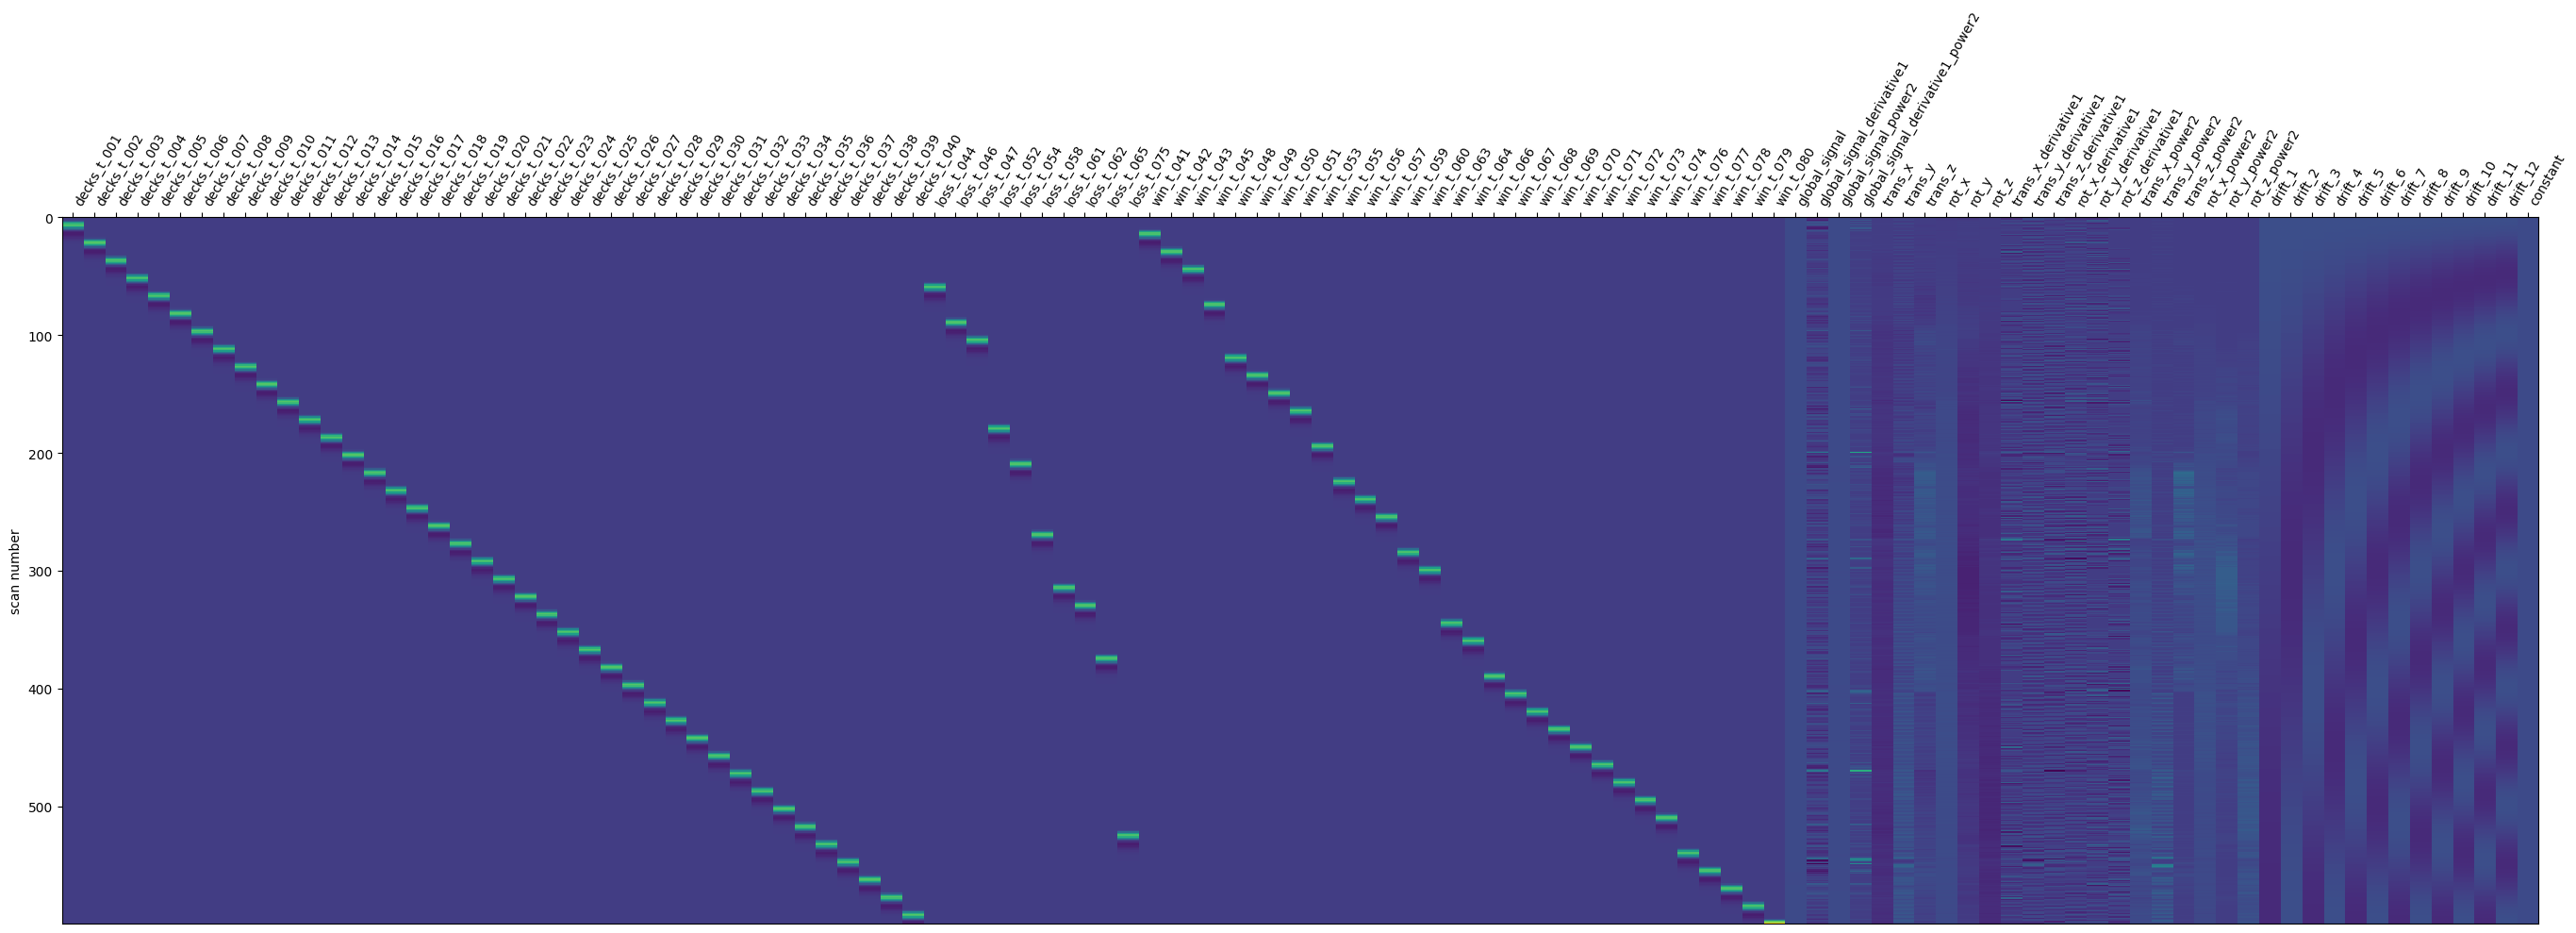

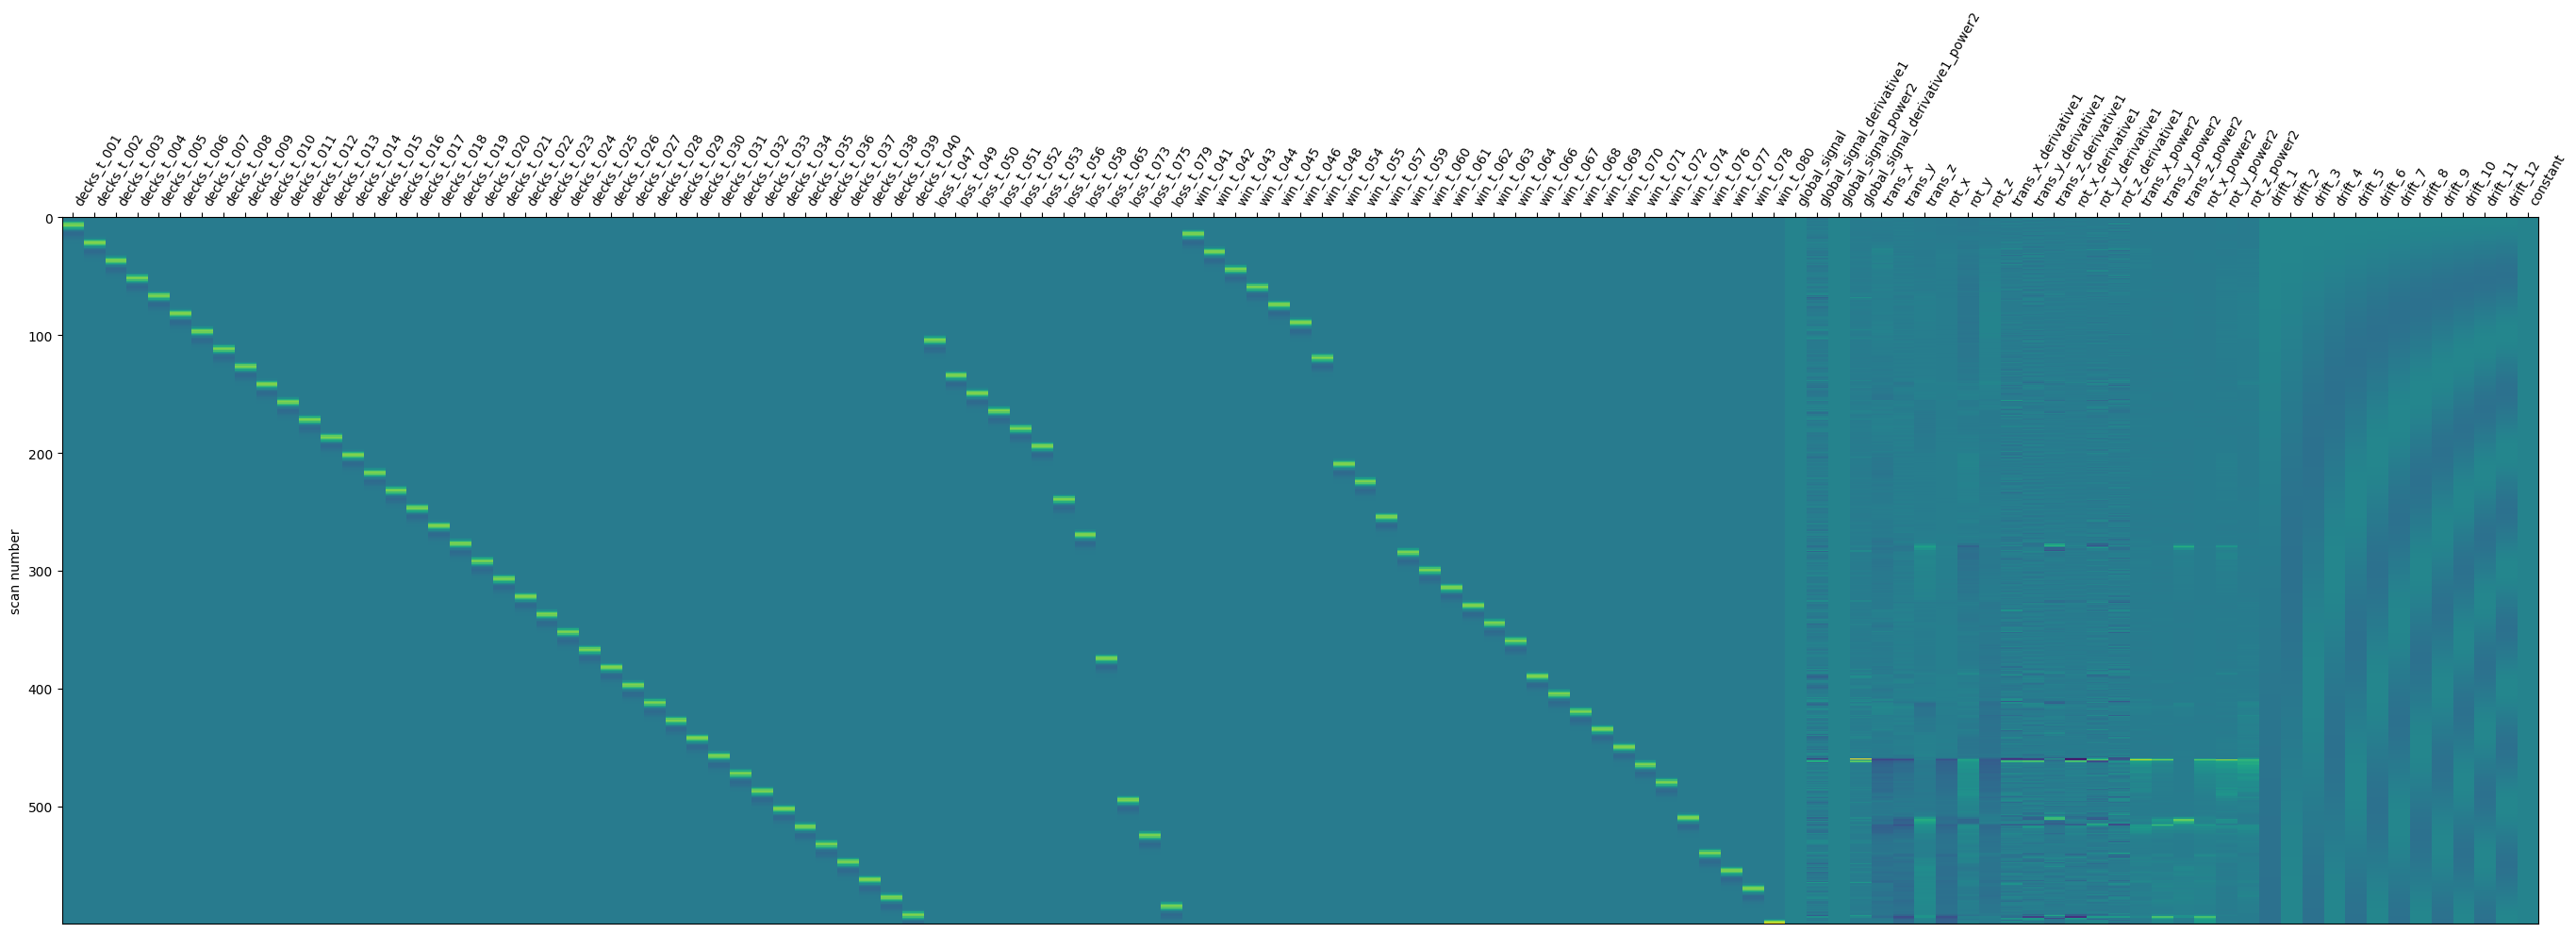

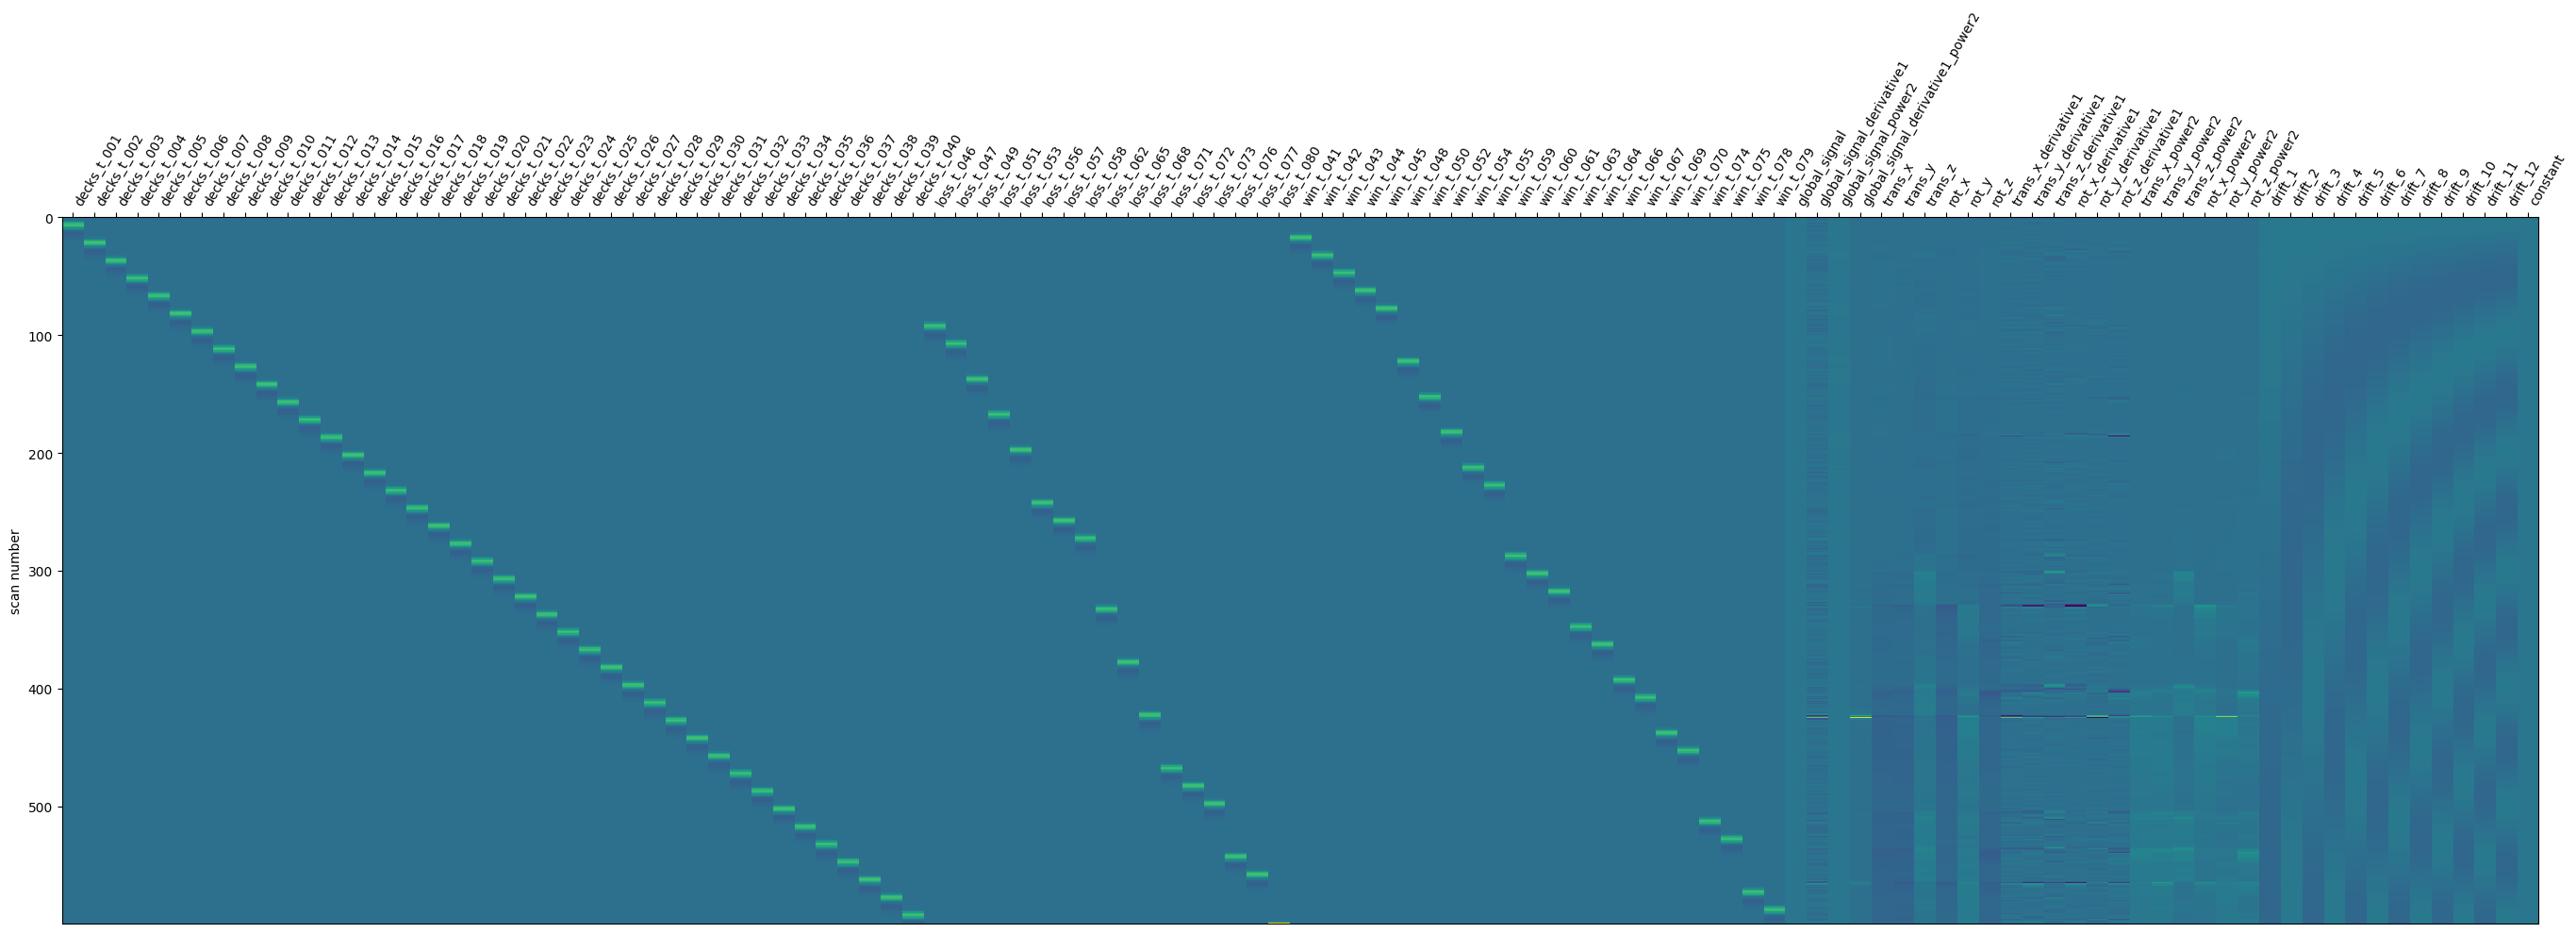

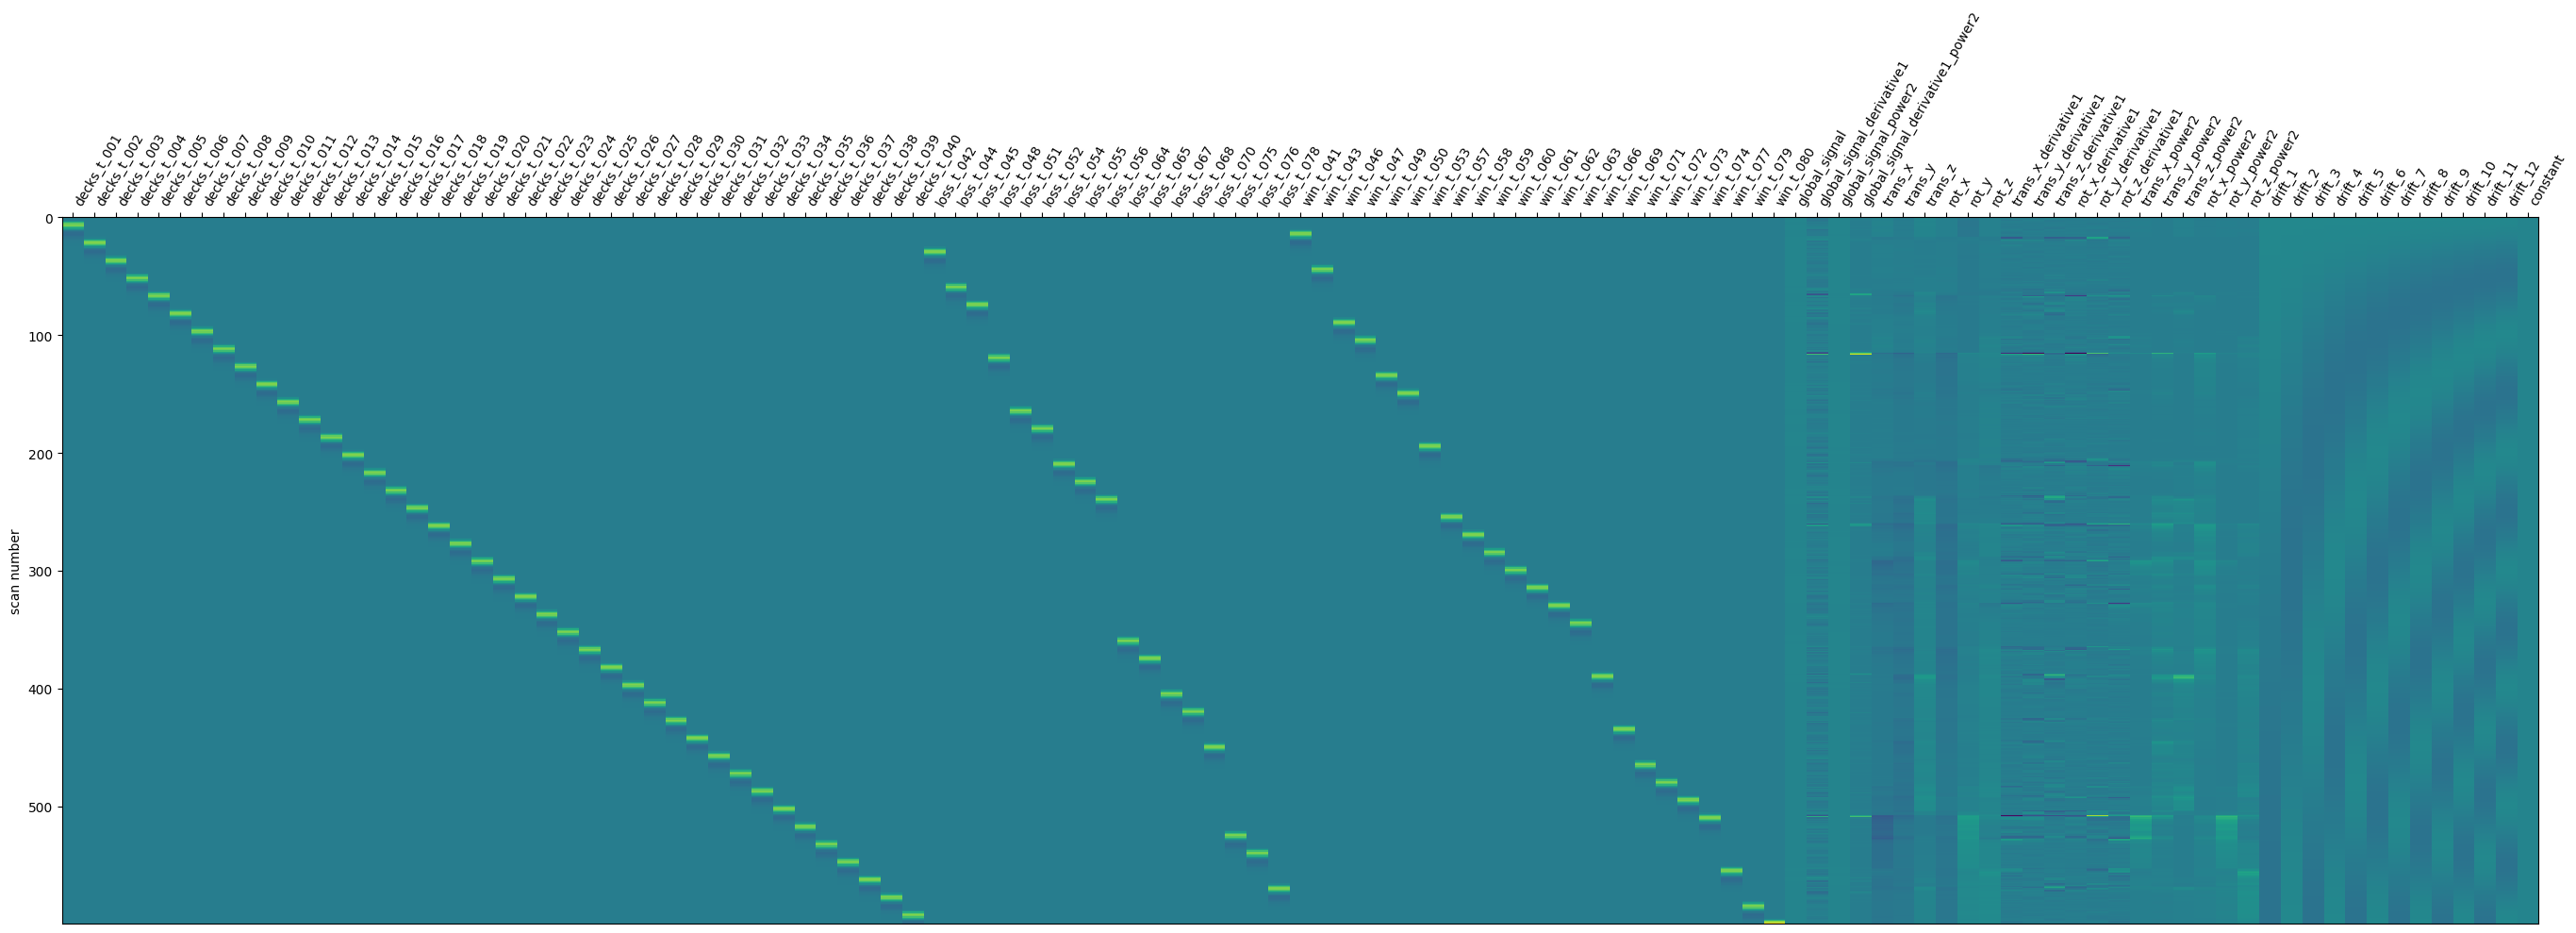

In [12]:
#print example design matrix 
for ii in range(len(models_events[0])):
    plot_design_matrix(lsa_dm[0][ii]);

#### Reshape Data and make Train and Test sets



In [3]:
def reshape_data(sub_ind, conditions_labels, b_maps):
    """ reshape data for one subject at a time """
    n_trials = len(conditions_labels[sub_ind])
    b_maps_conc = concat_imgs(b_maps[sub_ind])
    idx_decks = [int(i) for i in range(n_trials) if 'decks_' in conditions_labels[sub_ind][i]]
    idx_win = [int(i) for i in range(n_trials) if 'win_' in conditions_labels[sub_ind][i]]
    idx_loss = [int(i) for i in range(n_trials) if 'loss_' in conditions_labels[sub_ind][i]]
    for i in range(len(conditions_labels[sub_ind])):
        if i in idx_decks:
            conditions_labels[sub_ind][i] = 'decks'
        if i in idx_win:
            conditions_labels[sub_ind][i] = 'win'
        if i in idx_loss:
            conditions_labels[sub_ind][i] = 'loss'
    idx = np.concatenate((idx_win, idx_loss))
    condition = np.array(conditions_labels[sub_ind])[idx]
    b_maps_img = index_img(b_maps_conc, idx)
    return idx, condition, b_maps_img

In [4]:
# For each participant, reshape the data
idxs = []
conditions = []
b_maps_imgs = []

for i in range(len(models_t)):
    idx, condition, b_maps_img = reshape_data(i, conditions_labels, b_maps)
    idxs.append(idx)
    conditions.append(condition)
    b_maps_imgs.append(b_maps_img)

In [6]:
# Test that the indexes are the same
i = 1
print(models_events[i][0].loc[40:]['trial_type'].value_counts())
unique, counts = np.unique(conditions_labels[i][40:80], return_counts=True)
print(np.asarray((unique, counts)).T)

trial_type
win     31
loss     9
Name: count, dtype: int64
[['loss' '9']
 ['win' '31']]


In [11]:
# Split data for all subjects into train and test
y_train = []
y_test = []
X_train = []
X_test = []

for i in range(len(models_t)):
    idx2 = np.arange(conditions[i].shape[0])
    idx_train, idx_test, y_train_i, y_test_i = train_test_split(idx2, conditions[i], test_size=0.2)
    y_train.append(y_train_i)
    y_test.append(y_test_i)
    X_train.append(index_img(b_maps_imgs[i], idx_train))
    X_test.append(index_img(b_maps_imgs[i], idx_test))

In [26]:
decoders = []
f1 = []
acc = []
# For each participant fit a decoder and save the classification report 
for i in range(len(models)):
    decoder = Decoder(estimator = 'logistic_l1',cv = 10, t_r = 1, verbose = 0, n_jobs = -1)
    decoder.fit(X_train[i], y_train[i])
    y_pred = decoder.predict(X_test[i])
    report = classification_report(y_test[i], y_pred)
    decoders.append(decoder)
    subj = models[i].subject_label
    f1_i = f1_score(y_test[i], y_pred, average="weighted")
    f1.append([subj, f1_i])
    acc_i = balanced_accuracy_score(y_test[i], y_pred, adjusted = True)
    acc.append([subj, acc_i])
    report_path = open(f"../out/class_reports/rep_{subj}", 'w')
    report_path.write(report)
    report_path.close()
    print(f"Report for sub{subj} saved")

Report for sub0140 saved


/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

Report for sub0136 saved
Report for sub0141 saved


/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

Report for sub0139 saved
Report for sub0138 saved
Report for sub0142 saved


In [58]:
f1_m = []
for i in range(len(f1)): f1_m.append(f1[i][1])
print(f"The mean weighted f1 score: {mean(f1_m)}")
acc_m = []
for i in range(len(acc)): acc_m.append(acc[i][1])
print(f"The mean balanced accuracy score (adjusted): {mean(acc_m)}")

The mean weighted f1 score: 0.6681582558549871
The mean balanced accuracy score (adjusted): 0.020431600563179515


/work/LauraGivskovRahbek#6659/Assignment2_ACN/virt_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



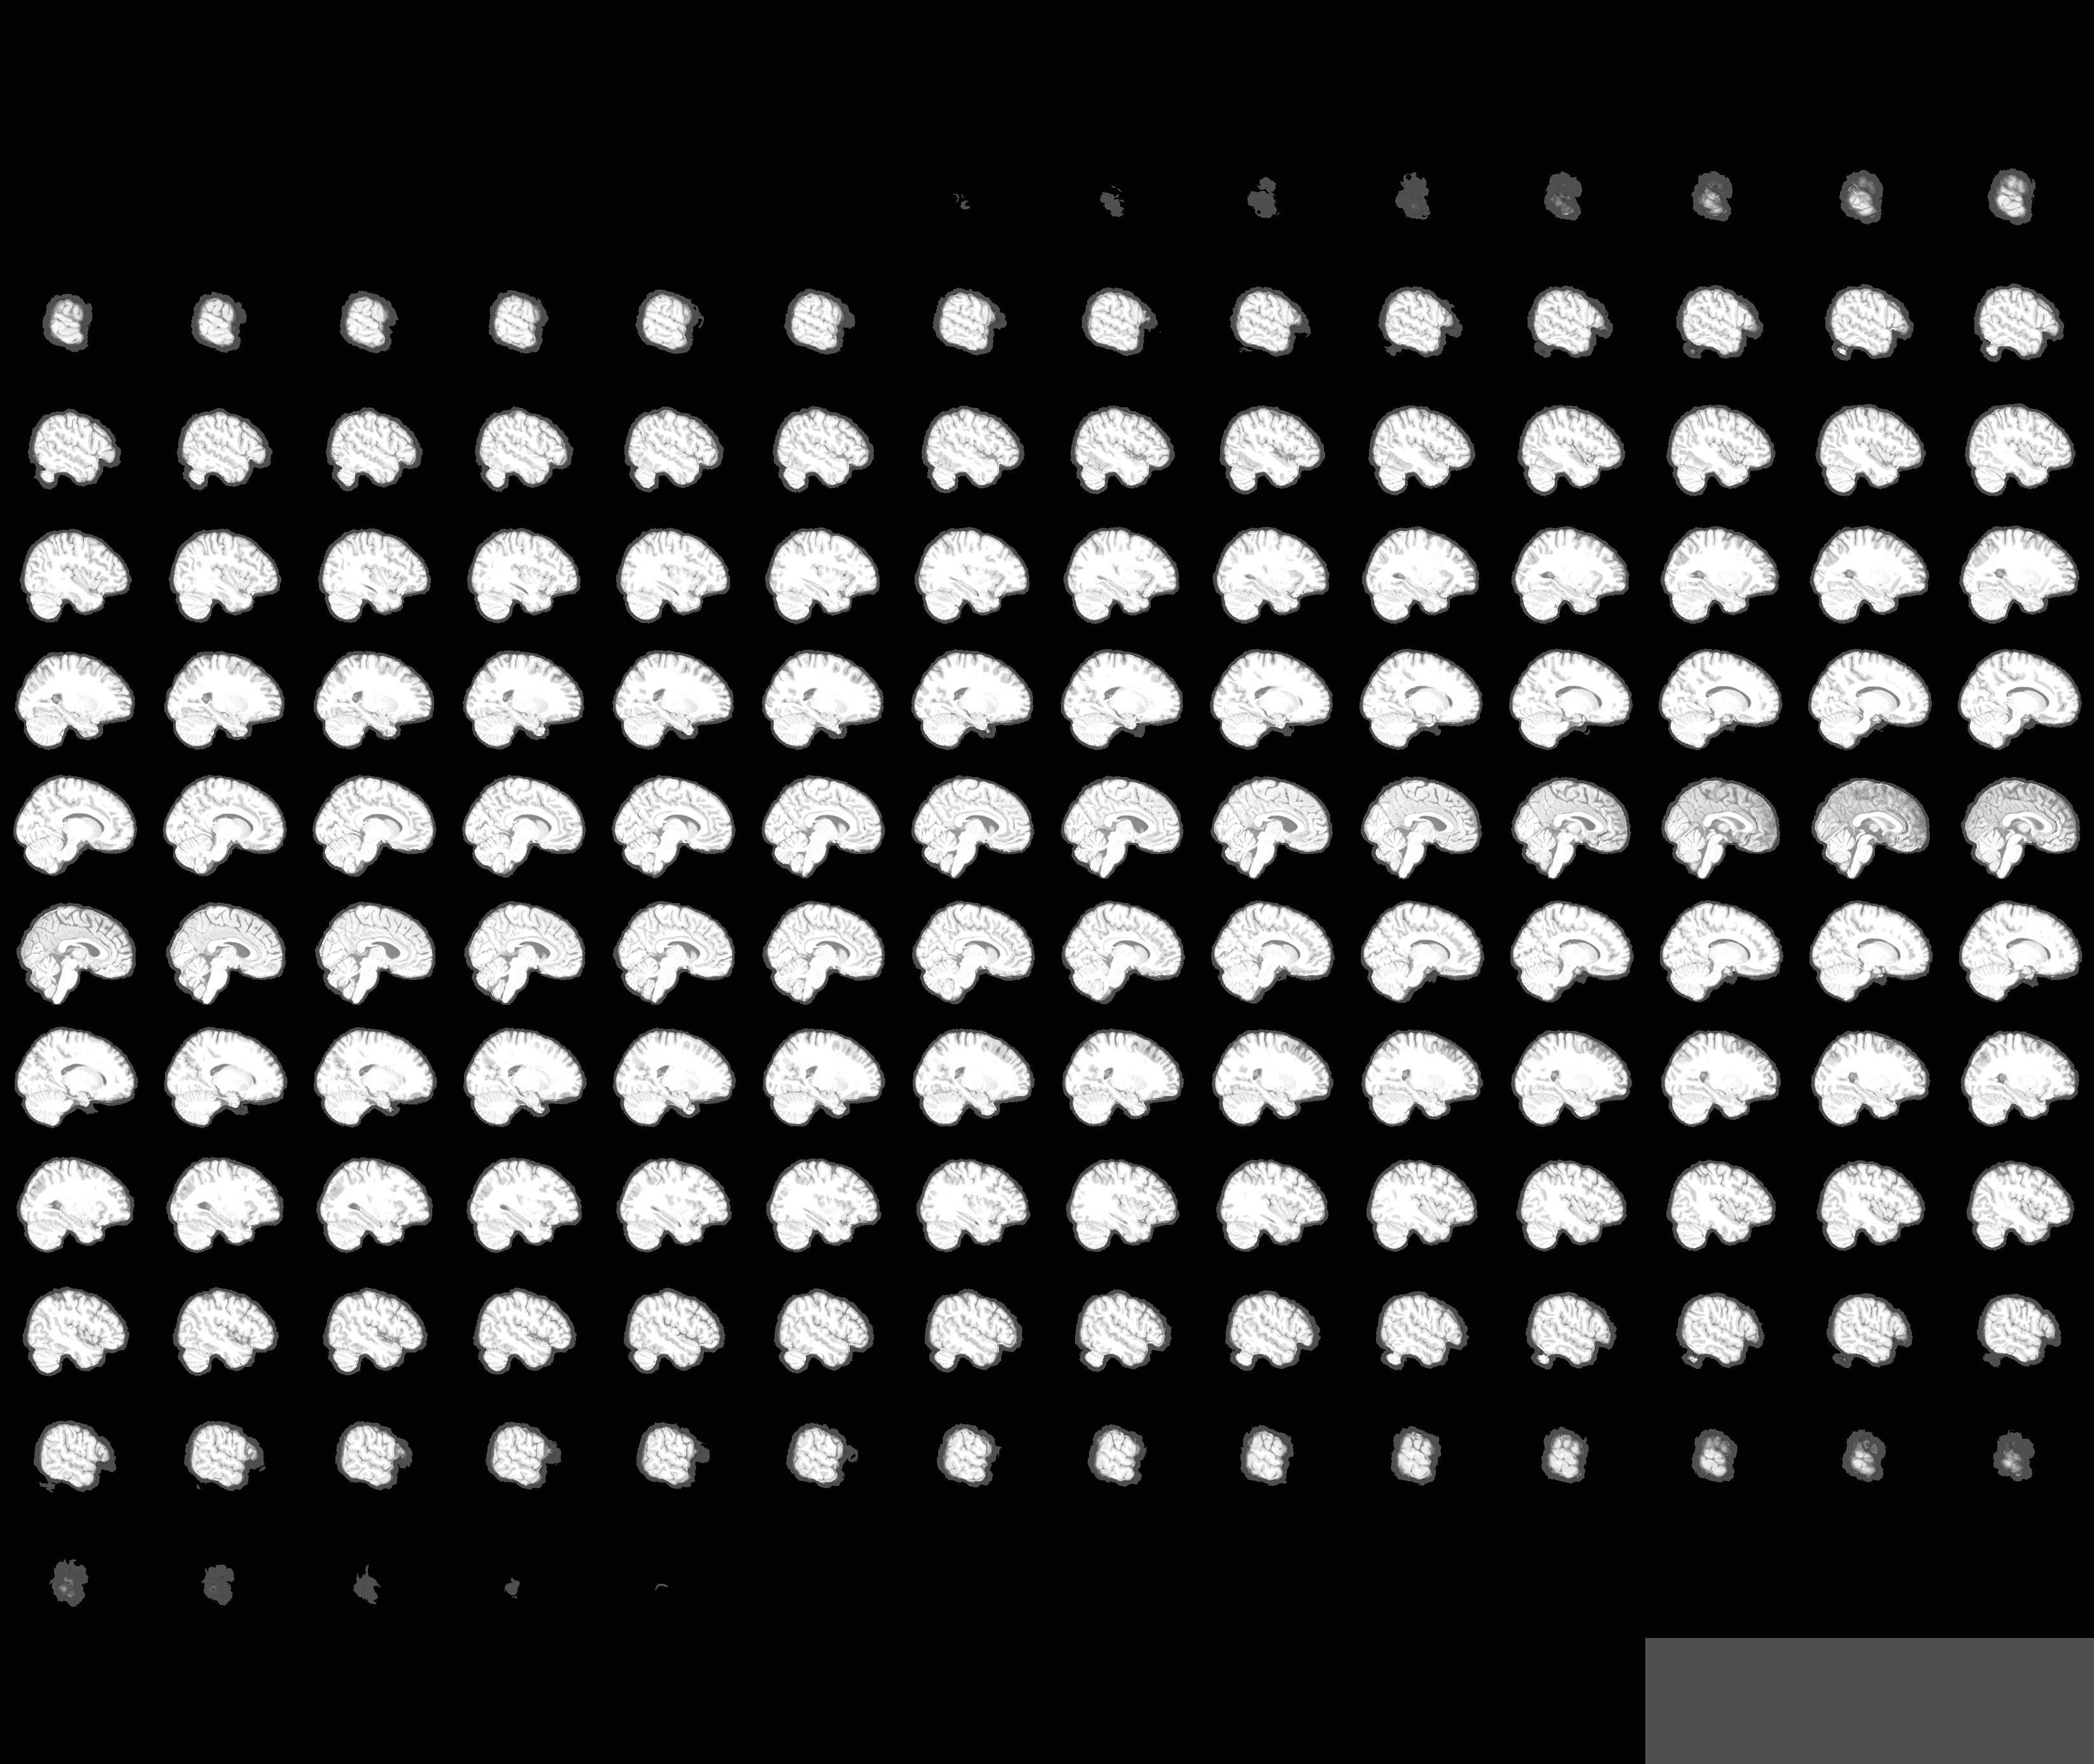
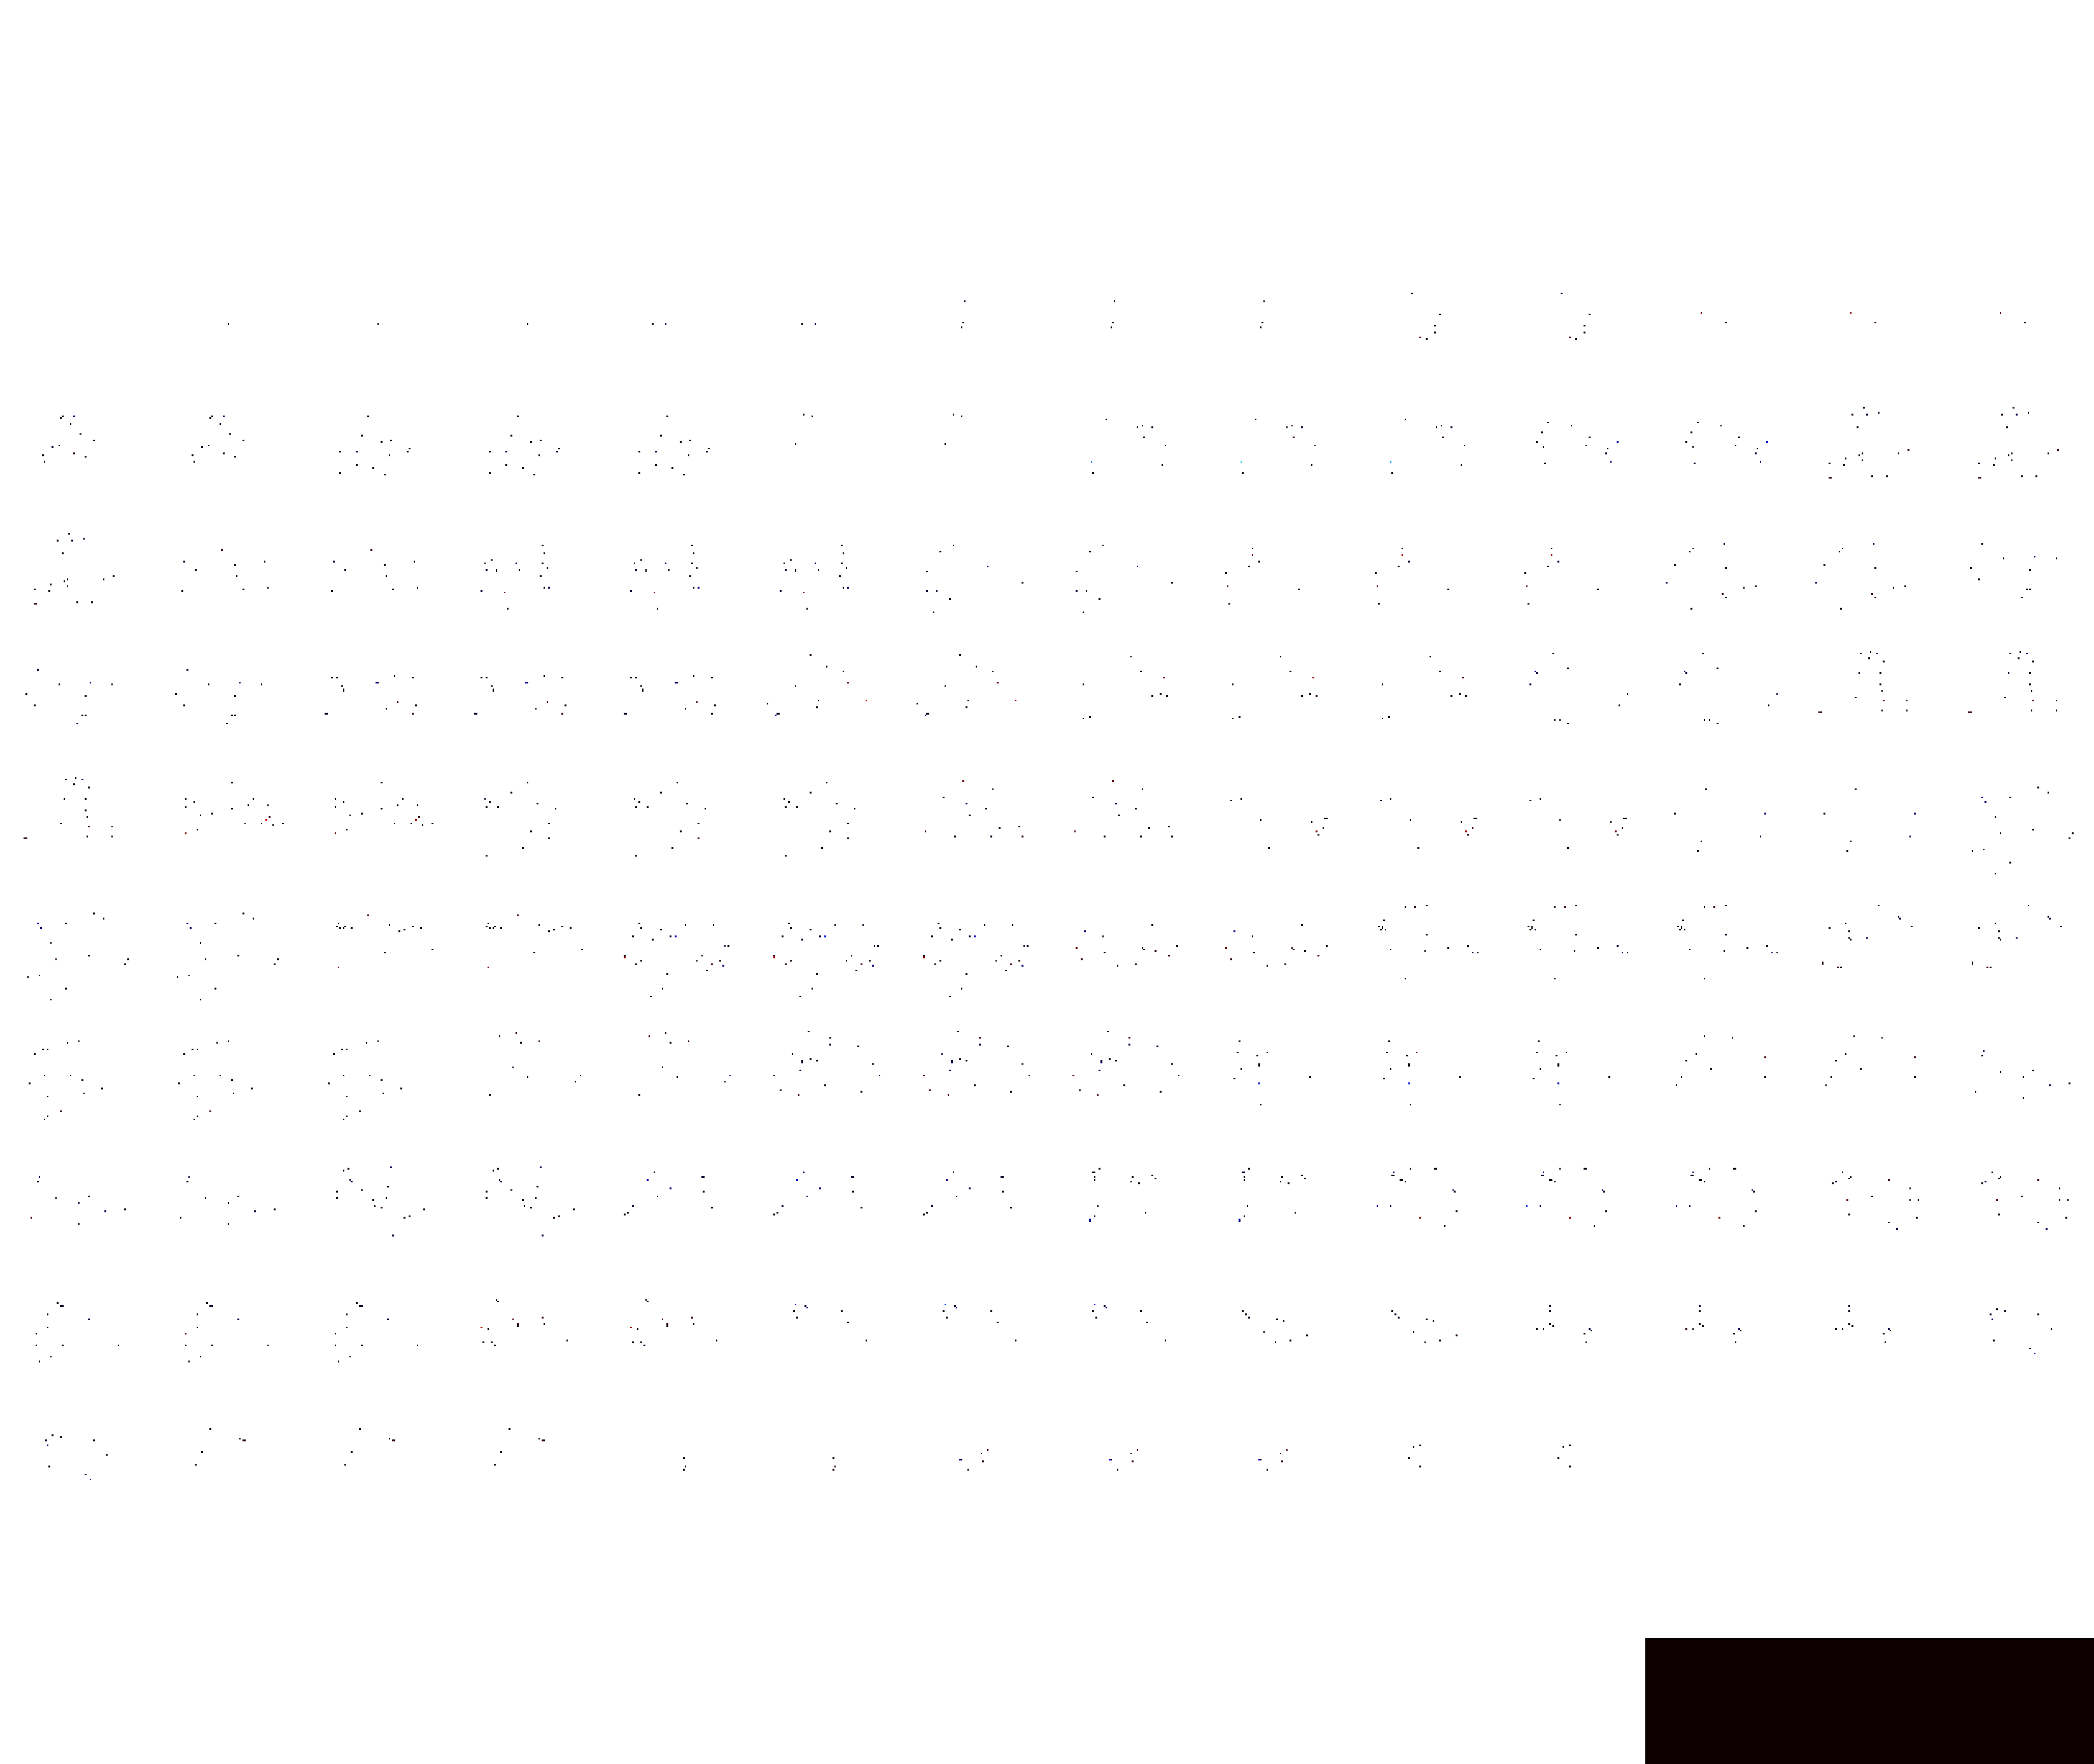

In [15]:
subj = models[5].subject_label
anat_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

plotting.view_img(
    decoder.coef_img_["loss"],
    bg_img=anat_filename,
    title="logistic weights",
    dim=-1,)